Training on: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
CUDA Version: 12.4
Epoch [10/100], Train Loss: 0.4235, Val Loss: 0.4075, Val Accuracy: 91.36%
Epoch [20/100], Train Loss: 0.2066, Val Loss: 0.2408, Val Accuracy: 93.28%
Epoch [30/100], Train Loss: 0.1641, Val Loss: 0.2077, Val Accuracy: 93.75%
Epoch [40/100], Train Loss: 0.1440, Val Loss: 0.1986, Val Accuracy: 93.93%
Epoch [50/100], Train Loss: 0.1328, Val Loss: 0.1920, Val Accuracy: 94.03%
Epoch [60/100], Train Loss: 0.1253, Val Loss: 0.1929, Val Accuracy: 93.97%
Epoch [70/100], Train Loss: 0.1208, Val Loss: 0.1896, Val Accuracy: 94.22%
Epoch [80/100], Train Loss: 0.1169, Val Loss: 0.1903, Val Accuracy: 94.33%
Epoch [90/100], Train Loss: 0.1150, Val Loss: 0.1922, Val Accuracy: 94.25%
Epoch [100/100], Train Loss: 0.1122, Val Loss: 0.1898, Val Accuracy: 94.30%

TRAINING RESULTS
Final Training Loss: 0.1122
Final Validation Loss: 0.1898
Final Validation Accuracy: 94.30%
Training Time: 15.62 seconds
Model Size: 0.24 MB
Device: cuda


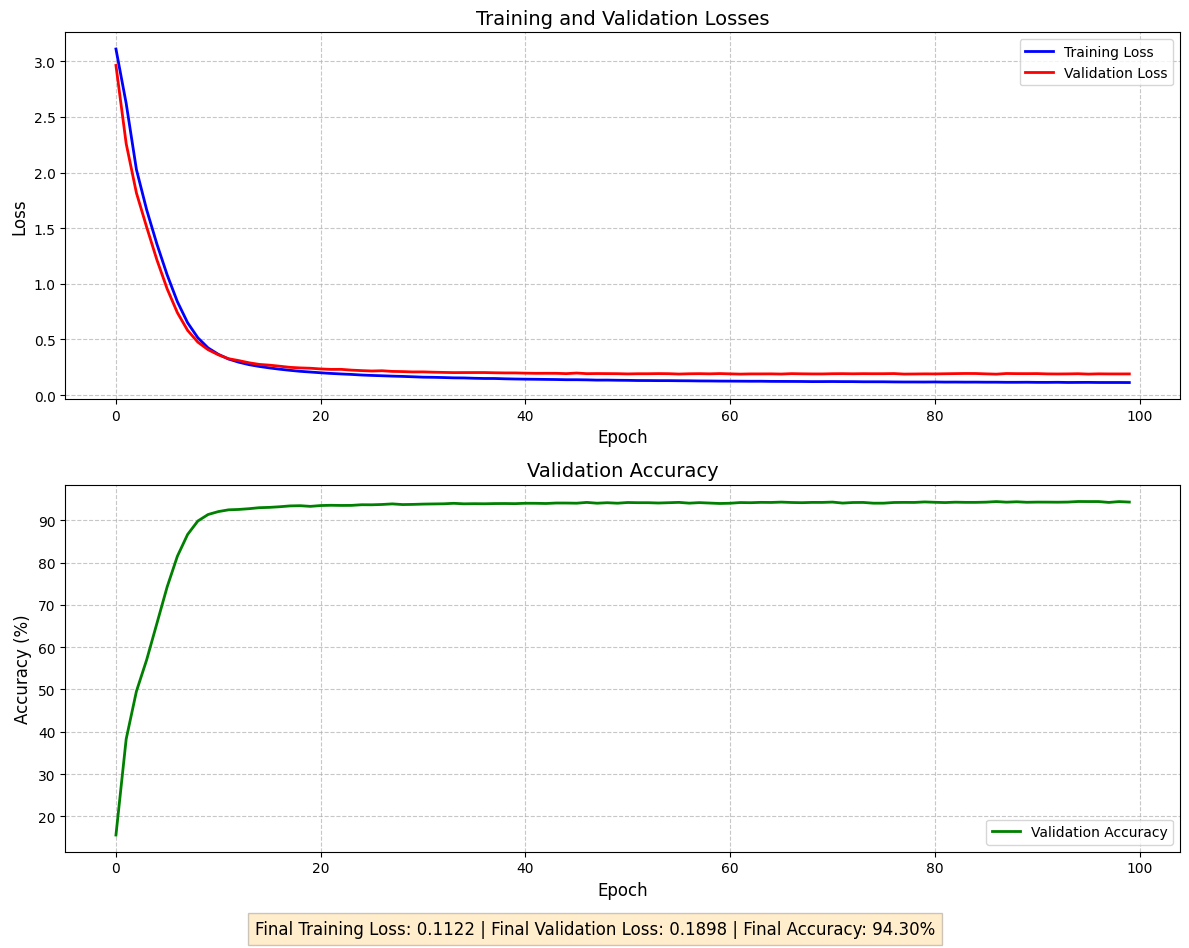

In [11]:
#Simple RNN

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#important to note hidden state is NOT the size of the sequence length
#but the size of the hidden state passed to the next layer

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialize the RNN model.
        
        Args:
            input_size (int): Size of input features
            hidden_size (int): Number of features in the hidden state
            num_layers (int): Number of recurrent layers
            output_size (int): Size of output features
        """
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # Expect input shape: (batch, seq_len, input_size)
        )
        
        # Fully connected layer to map RNN output to desired output size
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size)
            
        Returns:
            output (torch.Tensor): Output tensor of shape (batch_size, seq_length, output_size)
            hidden (torch.Tensor): Final hidden state
        """
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, hidden = self.rnn(x, h0)
        
        # Pass through fully connected layer
        # Reshape output to (batch_size * seq_length, hidden_size)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        
        # Reshape back to (batch_size, seq_length, output_size)
        out = out.view(batch_size, -1, out.size(-1))
        
        return out, hidden

# Example usage
class TextDataset(Dataset):
    def __init__(self, text, sequence_length):
        self.text = text
        self.sequence_length = sequence_length
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(set(text)))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.data_size = len(text) - sequence_length
        
    def __len__(self):
        return self.data_size
    
    def __getitem__(self, idx):
        # Get sequence and target
        sequence = self.text[idx:idx + self.sequence_length]
        target = self.text[idx + 1:idx + self.sequence_length + 1]
        
        # Convert to indices
        x = torch.tensor([self.char_to_idx[char] for char in sequence])
        y = torch.tensor([self.char_to_idx[char] for char in target])
        
        # One-hot encode
        x = torch.nn.functional.one_hot(x, num_classes=len(self.char_to_idx)).float()
        
        return x, y

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    
    start_time.record()
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            output, _ = model(batch_x)
            loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output, _ = model(batch_x)
                loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
                val_loss += loss.item()
                
                # Calculate accuracy
                predictions = output.view(-1, output.size(-1)).argmax(dim=1)
                targets = batch_y.view(-1)
                correct += (predictions == targets).sum().item()
                total += targets.size(0)
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.2f}%')
    
    end_time.record()
    torch.cuda.synchronize()
    training_time = start_time.elapsed_time(end_time) / 1000  # Convert to seconds
    
    return train_losses, val_losses, val_accuracies, training_time

def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

if __name__ == "__main__":
    # Read input text
    with open('input-text.txt', 'r') as f:
        text = f.read()
    
    # Hyperparameters
    sequence_length = 50
    hidden_size = 128
    num_layers = 2
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.001
    
    # Create dataset
    dataset = TextDataset(text, sequence_length)
    vocab_size = len(dataset.char_to_idx)
    
    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model and move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleRNN(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=vocab_size
    ).to(device)
    
    # Print device information
    print(f"Training on: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_losses, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, num_epochs, device
    )
    
    # Calculate model size
    model_size = get_model_size(model)
    
    # Report metrics
    print("\n" + "="*50)
    print("TRAINING RESULTS")
    print("="*50)
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Device: {device}")
    print("="*50)
    
    # Plot training and validation losses
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Losses', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Validation Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add text annotations for final values
    plt.figtext(0.5, 0.01, 
                f"Final Training Loss: {train_losses[-1]:.4f} | "
                f"Final Validation Loss: {val_losses[-1]:.4f} | "
                f"Final Accuracy: {val_accuracies[-1]:.2f}%",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the text
    
    # Display the plot in the notebook instead of saving it
    plt.show()
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'char_to_idx': dataset.char_to_idx,
        'idx_to_char': dataset.idx_to_char,
        'training_metrics': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'training_time': training_time,
            'model_size': model_size
        }
    }, 'rnn_model.pth')

def generate_text(model, char_to_idx, idx_to_char, seed_text, predict_len=100, temperature=0.8):
    """Generate text using the trained model.
    
    Args:
        model: Trained RNN model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
        seed_text: Initial text to start prediction from
        predict_len: Number of characters to generate
        temperature: Controls randomness (lower = more conservative)
    
    Returns:
        Generated text string
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Process seed text
    context = seed_text[-model.rnn.input_size:].ljust(model.rnn.input_size)
    generated_text = seed_text
    
    with torch.no_grad():
        for _ in range(predict_len):
            # Prepare input
            x = torch.tensor([char_to_idx[c] for c in context])
            x = torch.nn.functional.one_hot(x, num_classes=len(char_to_idx)).float()
            x = x.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get prediction
            output, _ = model(x)
            output = output[:, -1, :] / temperature  # Get last character prediction
            probs = torch.nn.functional.softmax(output, dim=-1)
            
            # Sample from the predicted probability distribution
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            
            # Update context and generated text
            generated_text += next_char
            context = context[1:] + next_char
    
    return generated_text

def load_model(model_path, device='cpu'):
    """Load a trained model and its character mappings.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on ('cpu' or 'cuda')
    
    Returns:
        model: Loaded model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
    """
    checkpoint = torch.load(model_path, map_location=device)
    char_to_idx = checkpoint['char_to_idx']
    idx_to_char = checkpoint['idx_to_char']
    
    # Initialize model with correct dimensions
    vocab_size = len(char_to_idx)
    model = SimpleRNN(
        input_size=vocab_size,
        hidden_size=128,  # Use the same parameters as during training
        num_layers=2,
        output_size=vocab_size
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, char_to_idx, idx_to_char


Training on: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
CUDA Version: 12.4
Epoch [10/100], Train Loss: 1.4271, Val Loss: 1.3987, Val Accuracy: 59.68%
Epoch [20/100], Train Loss: 0.4046, Val Loss: 0.4133, Val Accuracy: 90.86%
Epoch [30/100], Train Loss: 0.2160, Val Loss: 0.2485, Val Accuracy: 93.42%
Epoch [40/100], Train Loss: 0.1651, Val Loss: 0.2031, Val Accuracy: 94.09%
Epoch [50/100], Train Loss: 0.1413, Val Loss: 0.1854, Val Accuracy: 94.36%
Epoch [60/100], Train Loss: 0.1275, Val Loss: 0.1793, Val Accuracy: 94.44%
Epoch [70/100], Train Loss: 0.1184, Val Loss: 0.1761, Val Accuracy: 94.48%
Epoch [80/100], Train Loss: 0.1133, Val Loss: 0.1763, Val Accuracy: 94.62%
Epoch [90/100], Train Loss: 0.1095, Val Loss: 0.1725, Val Accuracy: 94.63%
Epoch [100/100], Train Loss: 0.1066, Val Loss: 0.1730, Val Accuracy: 94.70%

TRAINING RESULTS
Final Training Loss: 0.1066
Final Validation Loss: 0.1730
Final Validation Accuracy: 94.70%
Training Time: 17.19 seconds
Model Size: 0.87 MB
Device: cuda


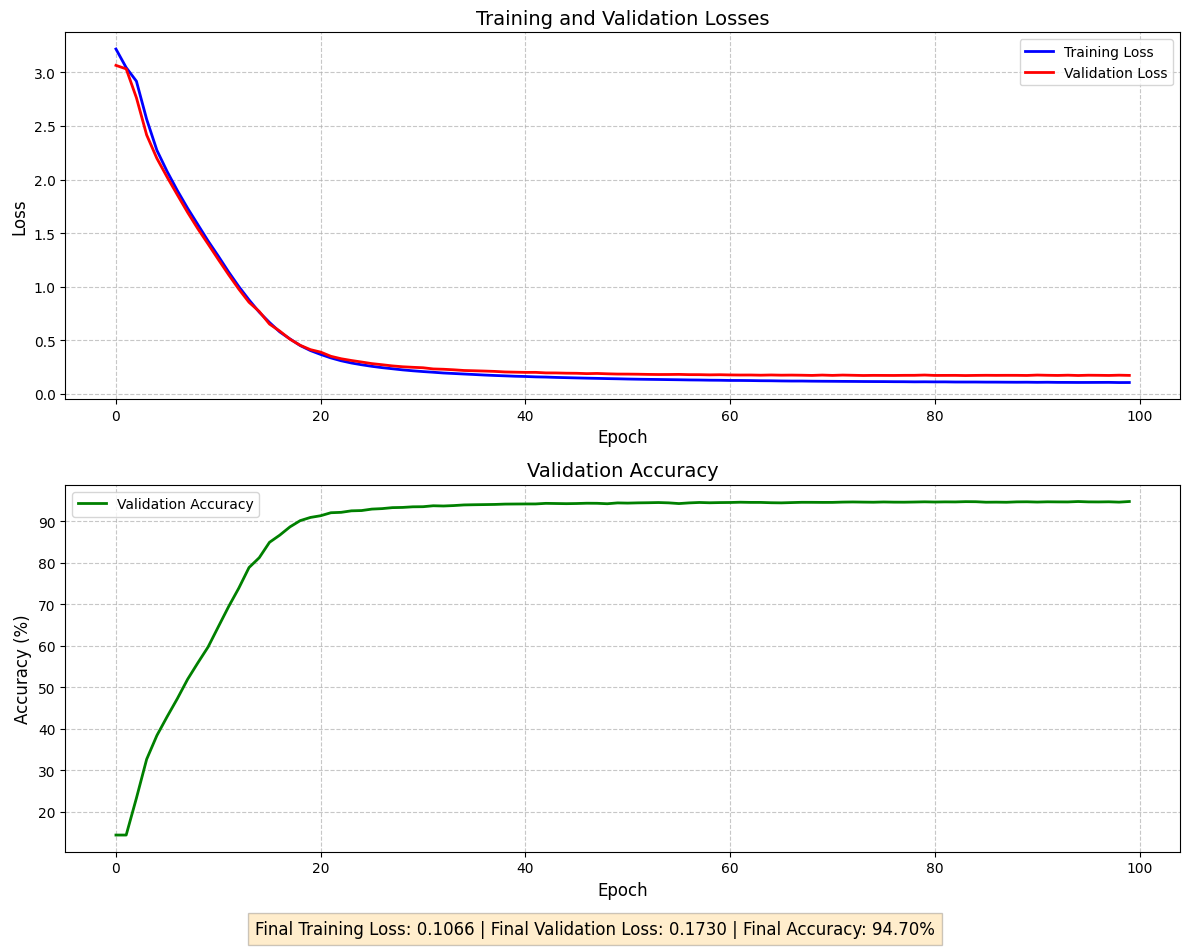

In [12]:
# simple rnn.LSTM
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialize the LSTM model.
        
        Args:
            input_size (int): Size of input features
            hidden_size (int): Number of features in the hidden state
            num_layers (int): Number of recurrent layers
            output_size (int): Size of output features
        """
        super(SimpleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer instead of RNN
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # Expect input shape: (batch, seq_len, input_size)
        )
        
        # Fully connected layer to map LSTM output to desired output size
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size)
            
        Returns:
            output (torch.Tensor): Output tensor of shape (batch_size, seq_length, output_size)
            hidden (tuple): Final hidden state and cell state
        """
        # Initialize hidden state and cell state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, (hidden, cell) = self.lstm(x, (h0, c0))
        
        # Pass through fully connected layer
        # Reshape output to (batch_size * seq_length, hidden_size)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        
        # Reshape back to (batch_size, seq_length, output_size)
        out = out.view(batch_size, -1, out.size(-1))
        
        return out, (hidden, cell)

# Example usage
class TextDataset(Dataset):
    def __init__(self, text, sequence_length):
        self.text = text
        self.sequence_length = sequence_length
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(set(text)))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.data_size = len(text) - sequence_length
        
    def __len__(self):
        return self.data_size
    
    def __getitem__(self, idx):
        # Get sequence and target
        sequence = self.text[idx:idx + self.sequence_length]
        target = self.text[idx + 1:idx + self.sequence_length + 1]
        
        # Convert to indices
        x = torch.tensor([self.char_to_idx[char] for char in sequence])
        y = torch.tensor([self.char_to_idx[char] for char in target])
        
        # One-hot encode
        x = torch.nn.functional.one_hot(x, num_classes=len(self.char_to_idx)).float()
        
        return x, y

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    
    start_time.record()
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            output, _ = model(batch_x)
            loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output, _ = model(batch_x)
                loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
                val_loss += loss.item()
                
                # Calculate accuracy
                predictions = output.view(-1, output.size(-1)).argmax(dim=1)
                targets = batch_y.view(-1)
                correct += (predictions == targets).sum().item()
                total += targets.size(0)
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.2f}%')
    
    end_time.record()
    torch.cuda.synchronize()
    training_time = start_time.elapsed_time(end_time) / 1000  # Convert to seconds
    
    return train_losses, val_losses, val_accuracies, training_time

def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

if __name__ == "__main__":
    # Read input text
    with open('input-text.txt', 'r') as f:
        text = f.read()
    
    # Hyperparameters
    sequence_length = 50
    hidden_size = 128
    num_layers = 2
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.001
    
    # Create dataset
    dataset = TextDataset(text, sequence_length)
    vocab_size = len(dataset.char_to_idx)
    
    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model and move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleLSTM(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=vocab_size
    ).to(device)
    
    # Print device information
    print(f"Training on: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_losses, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, num_epochs, device
    )
    
    # Calculate model size
    model_size = get_model_size(model)
    
    # Report metrics
    print("\n" + "="*50)
    print("TRAINING RESULTS")
    print("="*50)
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Device: {device}")
    print("="*50)
    
    # Plot training and validation losses
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Losses', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Validation Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add text annotations for final values
    plt.figtext(0.5, 0.01, 
                f"Final Training Loss: {train_losses[-1]:.4f} | "
                f"Final Validation Loss: {val_losses[-1]:.4f} | "
                f"Final Accuracy: {val_accuracies[-1]:.2f}%",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the text
    
    # Display the plot in the notebook instead of saving it
    plt.show()
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'char_to_idx': dataset.char_to_idx,
        'idx_to_char': dataset.idx_to_char,
        'training_metrics': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'training_time': training_time,
            'model_size': model_size
        }
    }, 'lstm_model.pth')

def generate_text(model, char_to_idx, idx_to_char, seed_text, predict_len=100, temperature=0.8):
    """Generate text using the trained model.
    
    Args:
        model: Trained LSTM model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
        seed_text: Initial text to start prediction from
        predict_len: Number of characters to generate
        temperature: Controls randomness (lower = more conservative)
    
    Returns:
        Generated text string
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Process seed text
    context = seed_text[-model.lstm.input_size:].ljust(model.lstm.input_size)
    generated_text = seed_text
    
    with torch.no_grad():
        for _ in range(predict_len):
            # Prepare input
            x = torch.tensor([char_to_idx[c] for c in context])
            x = torch.nn.functional.one_hot(x, num_classes=len(char_to_idx)).float()
            x = x.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get prediction
            output, _ = model(x)
            output = output[:, -1, :] / temperature  # Get last character prediction
            probs = torch.nn.functional.softmax(output, dim=-1)
            
            # Sample from the predicted probability distribution
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            
            # Update context and generated text
            generated_text += next_char
            context = context[1:] + next_char
    
    return generated_text

def load_model(model_path, device='cpu'):
    """Load a trained model and its character mappings.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on ('cpu' or 'cuda')
    
    Returns:
        model: Loaded model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
    """
    checkpoint = torch.load(model_path, map_location=device)
    char_to_idx = checkpoint['char_to_idx']
    idx_to_char = checkpoint['idx_to_char']
    
    # Initialize model with correct dimensions
    vocab_size = len(char_to_idx)
    model = SimpleLSTM(
        input_size=vocab_size,
        hidden_size=128,  # Use the same parameters as during training
        num_layers=2,
        output_size=vocab_size
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, char_to_idx, idx_to_char 

Training on: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
CUDA Version: 12.4
Epoch [10/100], Train Loss: 0.4120, Val Loss: 0.3910, Val Accuracy: 91.48%
Epoch [20/100], Train Loss: 0.1756, Val Loss: 0.2120, Val Accuracy: 93.96%
Epoch [30/100], Train Loss: 0.1415, Val Loss: 0.1909, Val Accuracy: 94.29%
Epoch [40/100], Train Loss: 0.1286, Val Loss: 0.1858, Val Accuracy: 94.33%
Epoch [50/100], Train Loss: 0.1194, Val Loss: 0.1825, Val Accuracy: 94.47%
Epoch [60/100], Train Loss: 0.1156, Val Loss: 0.1834, Val Accuracy: 94.42%
Epoch [70/100], Train Loss: 0.1125, Val Loss: 0.1832, Val Accuracy: 94.52%
Epoch [80/100], Train Loss: 0.1100, Val Loss: 0.1878, Val Accuracy: 94.37%
Epoch [90/100], Train Loss: 0.1081, Val Loss: 0.1871, Val Accuracy: 94.50%
Epoch [100/100], Train Loss: 0.1061, Val Loss: 0.1899, Val Accuracy: 94.48%

TRAINING RESULTS
Final Training Loss: 0.1061
Final Validation Loss: 0.1899
Final Validation Accuracy: 94.48%
Training Time: 16.15 seconds
Model Size: 0.66 MB
Device: cuda


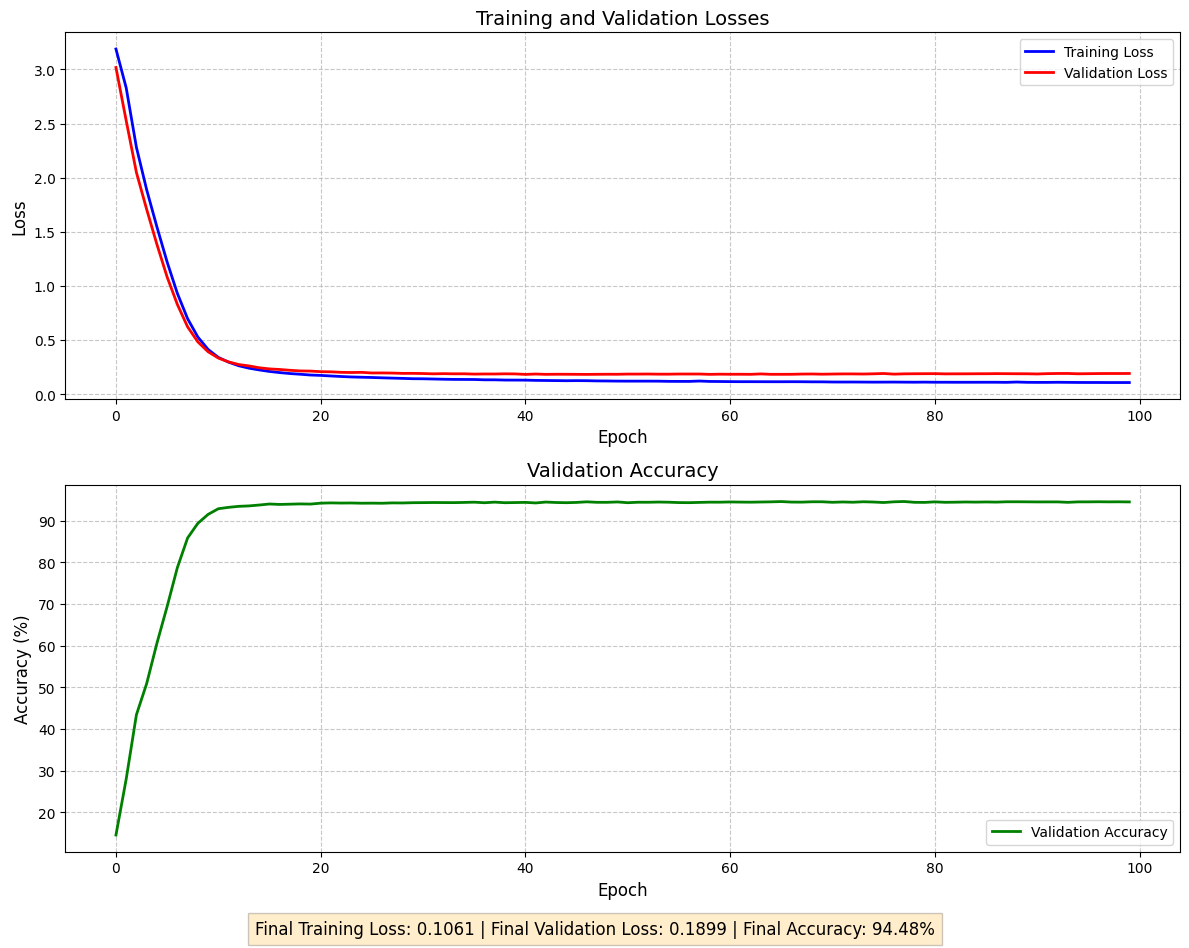

In [13]:
##SIMPLE rnn.GRU


class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialize the GRU model.
        
        Args:
            input_size (int): Size of input features
            hidden_size (int): Number of features in the hidden state
            num_layers (int): Number of recurrent layers
            output_size (int): Size of output features
        """
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer instead of LSTM
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # Expect input shape: (batch, seq_len, input_size)
        )
        
        # Fully connected layer to map GRU output to desired output size
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size)
            
        Returns:
            output (torch.Tensor): Output tensor of shape (batch_size, seq_length, output_size)
            hidden (torch.Tensor): Final hidden state
        """
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        # Note: GRU doesn't have a cell state like LSTM
        out, hidden = self.gru(x, h0)
        
        # Pass through fully connected layer
        # Reshape output to (batch_size * seq_length, hidden_size)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        
        # Reshape back to (batch_size, seq_length, output_size)
        out = out.view(batch_size, -1, out.size(-1))
        
        return out, hidden

# Example usage
class TextDataset(Dataset):
    def __init__(self, text, sequence_length):
        self.text = text
        self.sequence_length = sequence_length
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(set(text)))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.data_size = len(text) - sequence_length
        
    def __len__(self):
        return self.data_size
    
    def __getitem__(self, idx):
        # Get sequence and target
        sequence = self.text[idx:idx + self.sequence_length]
        target = self.text[idx + 1:idx + self.sequence_length + 1]
        
        # Convert to indices
        x = torch.tensor([self.char_to_idx[char] for char in sequence])
        y = torch.tensor([self.char_to_idx[char] for char in target])
        
        # One-hot encode
        x = torch.nn.functional.one_hot(x, num_classes=len(self.char_to_idx)).float()
        
        return x, y

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    
    start_time.record()
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            output, _ = model(batch_x)
            loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output, _ = model(batch_x)
                loss = criterion(output.view(-1, output.size(-1)), batch_y.view(-1))
                val_loss += loss.item()
                
                # Calculate accuracy
                predictions = output.view(-1, output.size(-1)).argmax(dim=1)
                targets = batch_y.view(-1)
                correct += (predictions == targets).sum().item()
                total += targets.size(0)
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.2f}%')
    
    end_time.record()
    torch.cuda.synchronize()
    training_time = start_time.elapsed_time(end_time) / 1000  # Convert to seconds
    
    return train_losses, val_losses, val_accuracies, training_time

def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

if __name__ == "__main__":
    # Read input text
    with open('input-text.txt', 'r') as f:
        text = f.read()
    
    # Hyperparameters
    sequence_length = 50
    hidden_size = 128
    num_layers = 2
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.001
    
    # Create dataset
    dataset = TextDataset(text, sequence_length)
    vocab_size = len(dataset.char_to_idx)
    
    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model and move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleGRU(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=vocab_size
    ).to(device)
    
    # Print device information
    print(f"Training on: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_losses, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, num_epochs, device
    )
    
    # Calculate model size
    model_size = get_model_size(model)
    
    # Report metrics
    print("\n" + "="*50)
    print("TRAINING RESULTS")
    print("="*50)
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Device: {device}")
    print("="*50)
    
    # Plot training and validation losses
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Losses', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Validation Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add text annotations for final values
    plt.figtext(0.5, 0.01, 
                f"Final Training Loss: {train_losses[-1]:.4f} | "
                f"Final Validation Loss: {val_losses[-1]:.4f} | "
                f"Final Accuracy: {val_accuracies[-1]:.2f}%",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the text
    
    # Display the plot in the notebook instead of saving it
    plt.show()
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'char_to_idx': dataset.char_to_idx,
        'idx_to_char': dataset.idx_to_char,
        'training_metrics': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'training_time': training_time,
            'model_size': model_size
        }
    }, 'gru_model.pth')

def generate_text(model, char_to_idx, idx_to_char, seed_text, predict_len=100, temperature=0.8):
    """Generate text using the trained model.
    
    Args:
        model: Trained GRU model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
        seed_text: Initial text to start prediction from
        predict_len: Number of characters to generate
        temperature: Controls randomness (lower = more conservative)
    
    Returns:
        Generated text string
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Process seed text
    context = seed_text[-model.gru.input_size:].ljust(model.gru.input_size)
    generated_text = seed_text
    
    with torch.no_grad():
        for _ in range(predict_len):
            # Prepare input
            x = torch.tensor([char_to_idx[c] for c in context])
            x = torch.nn.functional.one_hot(x, num_classes=len(char_to_idx)).float()
            x = x.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get prediction
            output, _ = model(x)
            output = output[:, -1, :] / temperature  # Get last character prediction
            probs = torch.nn.functional.softmax(output, dim=-1)
            
            # Sample from the predicted probability distribution
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            
            # Update context and generated text
            generated_text += next_char
            context = context[1:] + next_char
    
    return generated_text

def load_model(model_path, device='cpu'):
    """Load a trained model and its character mappings.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on ('cpu' or 'cuda')
    
    Returns:
        model: Loaded model
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
    """
    checkpoint = torch.load(model_path, map_location=device)
    char_to_idx = checkpoint['char_to_idx']
    idx_to_char = checkpoint['idx_to_char']
    
    # Initialize model with correct dimensions
    vocab_size = len(char_to_idx)
    model = SimpleGRU(
        input_size=vocab_size,
        hidden_size=128,  # Use the same parameters as during training
        num_layers=2,
        output_size=vocab_size
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, char_to_idx, idx_to_char 

Training LSTM model...
Training LSTM on: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
batch_x shape: torch.Size([128, 20])
batch_y shape: torch.Size([128])
batch_x_one_hot shape: torch.Size([128, 20, 65])
output shape: torch.Size([128, 20, 65])
output[:, -1, :] shape: torch.Size([128, 65])
batch_y shape: torch.Size([128])
Epoch [5/30], Train Loss: 1.4038, Test Loss: 1.4196, Test Accuracy: 56.74%
Epoch [10/30], Train Loss: 1.3059, Test Loss: 1.3753, Test Accuracy: 57.89%
Epoch [15/30], Train Loss: 1.2596, Test Loss: 1.3647, Test Accuracy: 58.25%
Epoch [20/30], Train Loss: 1.2292, Test Loss: 1.3682, Test Accuracy: 58.26%
Epoch [25/30], Train Loss: 1.2072, Test Loss: 1.3775, Test Accuracy: 58.16%
Epoch [30/30], Train Loss: 1.1904, Test Loss: 1.3873, Test Accuracy: 58.01%

LSTM TRAINING RESULTS
Final Training Loss: 1.1904
Final Test Loss: 1.3873
Final Test Accuracy: 58.01%
Training Time: 470.52 seconds
Model Size: 0.92 MB

Training GRU model...
Training GRU on: cuda
GPU: NVIDIA GeForce RTX 3080 Ti

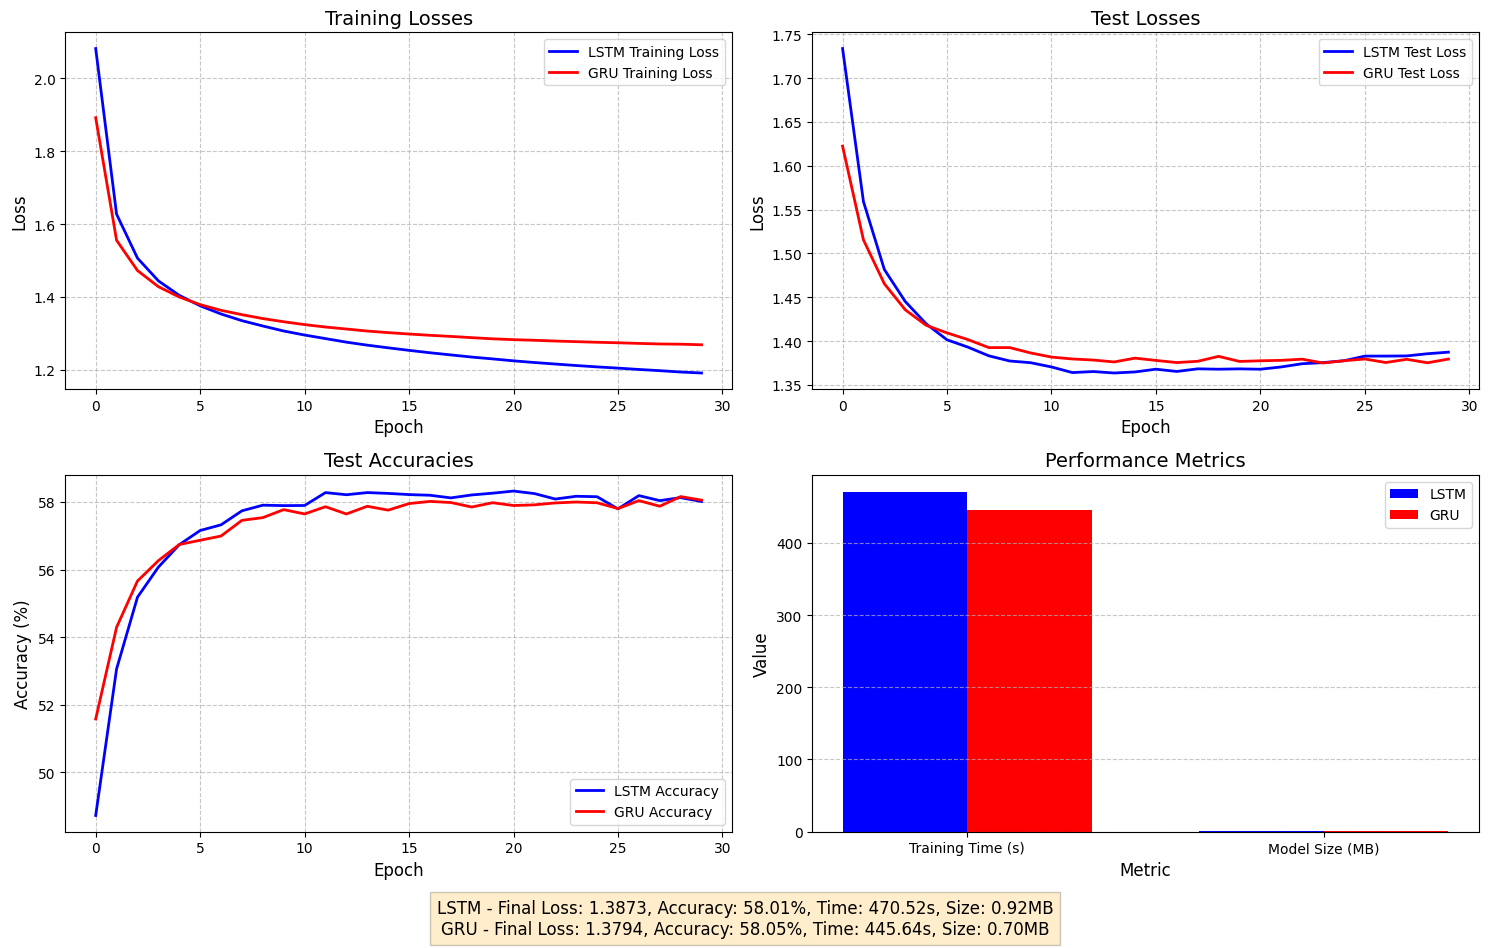


Generating text with LSTM model:
The quick brown fox jumps over the lazy dogs
contented the wisdom to be married with the first for the furthest bare way
And spirit is present 

Generating text with GRU model:
The quick brown fox jumps over the lazy dog, to do the servant weeds.

LADY MANEMAR:
How love the villain lady;
She we had a will I that spoke,

MODEL COMPARISON SUMMARY
LSTM Final Test Loss: 1.3873
GRU Final Test Loss: 1.3794
LSTM Final Test Accuracy: 58.01%
GRU Final Test Accuracy: 58.05%
LSTM Training Time: 470.52 seconds
GRU Training Time: 445.64 seconds
LSTM Model Size: 0.92 MB
GRU Model Size: 0.70 MB

WINNERS BY CATEGORY:
Best Accuracy: GRU
Best Loss: GRU
Fastest Training: GRU
Smallest Model: GRU


In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader

# Import the Shakespeare dataloader
from shakespear_loader import char_to_int, int_to_char, train_loader, test_loader

# Define the RNN models (LSTM and GRU)
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, rnn_type='lstm'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()
        
        # Choose RNN type
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'lstm' or 'gru'")
            
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        # Initial hidden state
        batch_size = x.size(0)
        if hidden is None:
            if self.rnn_type == 'lstm':
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
                hidden = (h0, c0)
            else:  # GRU
                hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward pass through RNN
        out, hidden = self.rnn(x, hidden)
        
        # Decode the hidden state
        out = self.fc(out)
        return out, hidden

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    """Train the model and evaluate on test set."""
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    # For timing
    start_time = time.time()
    
    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Print shapes for debugging (only first batch of first epoch)
            if epoch == 1 and batch_idx == 0:
                print(f"batch_x shape: {batch_x.shape}")
                print(f"batch_y shape: {batch_y.shape}")
            
            # Convert inputs to one-hot encoding
            batch_x_one_hot = torch.nn.functional.one_hot(batch_x, num_classes=len(char_to_int)).float()
            
            # Print one-hot shape for debugging (only first batch of first epoch)
            if epoch == 1 and batch_idx == 0:
                print(f"batch_x_one_hot shape: {batch_x_one_hot.shape}")
            
            # Forward pass
            output, _ = model(batch_x_one_hot)
            
            # Print output shape for debugging (only first batch of first epoch)
            if epoch == 1 and batch_idx == 0:
                print(f"output shape: {output.shape}")
                print(f"output[:, -1, :] shape: {output[:, -1, :].shape}")
                print(f"batch_y shape: {batch_y.shape}")
            
            # We only need to predict the next character (which is our target)
            loss = criterion(output[:, -1, :], batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                # Convert inputs to one-hot encoding
                batch_x_one_hot = torch.nn.functional.one_hot(batch_x, num_classes=len(char_to_int)).float()
                
                # Forward pass
                output, _ = model(batch_x_one_hot)
                
                # We only need to predict the next character (which is our target)
                loss = criterion(output[:, -1, :], batch_y)
                
                test_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output[:, -1, :], 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        # Average test loss and accuracy
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    
    training_time = time.time() - start_time
    
    return train_losses, test_losses, test_accuracies, training_time

# Generate text function
def generate_text(model, seed_text, predict_len=100, temperature=0.8):
    """Generate text using the trained model."""
    model.eval()
    device = next(model.parameters()).device
    
    # Process seed text
    context = [char_to_int[c] for c in seed_text]
    generated_text = seed_text
    
    with torch.no_grad():
        for _ in range(predict_len):
            # Prepare input
            x = torch.tensor(context[-20:]).unsqueeze(0).to(device)  # Use last 20 chars
            x_one_hot = torch.nn.functional.one_hot(x, num_classes=len(char_to_int)).float()
            
            # Get prediction
            output, _ = model(x_one_hot)
            output = output[:, -1, :] / temperature  # Get last character prediction
            probs = torch.nn.functional.softmax(output, dim=-1)
            
            # Sample from the predicted probability distribution
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = int_to_char[next_char_idx]
            
            # Update context and generated text
            generated_text += next_char
            context.append(next_char_idx)
    
    return generated_text

# Get model size
def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# Function to train and evaluate a model
def train_and_evaluate(rnn_type):
    """Train and evaluate a model with the specified RNN type"""
    # Hyperparameters
    hidden_size = 128
    num_layers = 2
    num_epochs = 30
    learning_rate = 0.001
    
    # Get vocabulary size
    vocab_size = len(char_to_int)
    
    # Initialize model and move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNModel(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=vocab_size,
        rnn_type=rnn_type
    ).to(device)
    
    # Print device information
    print(f"Training {rnn_type.upper()} on: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_losses, test_losses, test_accuracies, training_time = train_model(
        model, train_loader, test_loader,
        criterion, optimizer, num_epochs, device
    )
    
    # Calculate model size
    model_size = get_model_size(model)
    
    # Report metrics
    print("\n" + "="*50)
    print(f"{rnn_type.upper()} TRAINING RESULTS")
    print("="*50)
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Model Size: {model_size:.2f} MB")
    print("="*50)
    
    return model, train_losses, test_losses, test_accuracies, training_time, model_size

# Function to compare models
def compare_models(lstm_results, gru_results):
    """Compare the performance of LSTM and GRU models"""
    # Unpack results
    lstm_model, lstm_train_losses, lstm_test_losses, lstm_accuracies, lstm_time, lstm_size = lstm_results
    gru_model, gru_train_losses, gru_test_losses, gru_accuracies, gru_time, gru_size = gru_results
    
    # Plot training and test losses
    plt.figure(figsize=(15, 10))
    
    # Plot training losses
    plt.subplot(2, 2, 1)
    plt.plot(lstm_train_losses, label='LSTM Training Loss', color='blue', linewidth=2)
    plt.plot(gru_train_losses, label='GRU Training Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training Losses', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Plot test losses
    plt.subplot(2, 2, 2)
    plt.plot(lstm_test_losses, label='LSTM Test Loss', color='blue', linewidth=2)
    plt.plot(gru_test_losses, label='GRU Test Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Test Losses', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Plot test accuracies
    plt.subplot(2, 2, 3)
    plt.plot(lstm_accuracies, label='LSTM Accuracy', color='blue', linewidth=2)
    plt.plot(gru_accuracies, label='GRU Accuracy', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Test Accuracies', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Bar chart for training time and model size
    plt.subplot(2, 2, 4)
    metrics = ['Training Time (s)', 'Model Size (MB)']
    lstm_values = [lstm_time, lstm_size]
    gru_values = [gru_time, gru_size]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, lstm_values, width, label='LSTM', color='blue')
    plt.bar(x + width/2, gru_values, width, label='GRU', color='red')
    
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title('Performance Metrics', fontsize=14)
    plt.xticks(x, metrics)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.legend(fontsize=10)
    
    # Add text summary
    plt.figtext(0.5, 0.01, 
                f"LSTM - Final Loss: {lstm_test_losses[-1]:.4f}, Accuracy: {lstm_accuracies[-1]:.2f}%, Time: {lstm_time:.2f}s, Size: {lstm_size:.2f}MB\n"
                f"GRU - Final Loss: {gru_test_losses[-1]:.4f}, Accuracy: {gru_accuracies[-1]:.2f}%, Time: {gru_time:.2f}s, Size: {gru_size:.2f}MB",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig('lstm_vs_gru_comparison.png')
    plt.show()
    
    # Generate text with both models
    seed_text = "The quick brown fox jumps over the lazy dog"
    
    print("\nGenerating text with LSTM model:")
    lstm_generated = generate_text(lstm_model, seed_text)
    print(lstm_generated)
    
    print("\nGenerating text with GRU model:")
    gru_generated = generate_text(gru_model, seed_text)
    print(gru_generated)
    
    # Print comparison summary
    print("\n" + "="*50)
    print("MODEL COMPARISON SUMMARY")
    print("="*50)
    print(f"LSTM Final Test Loss: {lstm_test_losses[-1]:.4f}")
    print(f"GRU Final Test Loss: {gru_test_losses[-1]:.4f}")
    print(f"LSTM Final Test Accuracy: {lstm_accuracies[-1]:.2f}%")
    print(f"GRU Final Test Accuracy: {gru_accuracies[-1]:.2f}%")
    print(f"LSTM Training Time: {lstm_time:.2f} seconds")
    print(f"GRU Training Time: {gru_time:.2f} seconds")
    print(f"LSTM Model Size: {lstm_size:.2f} MB")
    print(f"GRU Model Size: {gru_size:.2f} MB")
    
    # Determine which model performed better
    if lstm_accuracies[-1] > gru_accuracies[-1]:
        accuracy_winner = "LSTM"
    elif lstm_accuracies[-1] < gru_accuracies[-1]:
        accuracy_winner = "GRU"
    else:
        accuracy_winner = "Tie"
        
    if lstm_test_losses[-1] < gru_test_losses[-1]:
        loss_winner = "LSTM"
    elif lstm_test_losses[-1] > gru_test_losses[-1]:
        loss_winner = "GRU"
    else:
        loss_winner = "Tie"
        
    if lstm_time < gru_time:
        time_winner = "LSTM"
    elif lstm_time > gru_time:
        time_winner = "GRU"
    else:
        time_winner = "Tie"
        
    if lstm_size < gru_size:
        size_winner = "LSTM"
    elif lstm_size > gru_size:
        size_winner = "GRU"
    else:
        size_winner = "Tie"
    
    print("\nWINNERS BY CATEGORY:")
    print(f"Best Accuracy: {accuracy_winner}")
    print(f"Best Loss: {loss_winner}")
    print(f"Fastest Training: {time_winner}")
    print(f"Smallest Model: {size_winner}")
    print("="*50)

if __name__ == "__main__":
    # Train LSTM model
    print("Training LSTM model...")
    lstm_results = train_and_evaluate(rnn_type='lstm')
    
    # Train GRU model
    print("\nTraining GRU model...")
    gru_results = train_and_evaluate(rnn_type='gru')
    
    # Compare the models
    compare_models(lstm_results, gru_results)
